In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm
import itertools

from scipy.optimize import curve_fit
import powerlaw

import sys
sys.path.append('../')
from tracker import loadAntData, pltsaveall, discretizeTrajectory

# Update source files before running each cell
%load_ext autoreload
%autoreload 2

From tracker/_init__.py:
SLEAP not detected; make sure to install SLEAP if intending to use postprocessing notebook. Otherwise, ignore this message.


In [12]:
dataFile = '/home/jack/Workspaces/data/ant_tracking/simulated_ant_dataset_5_2025-12-04.h5'

minimumLength = 5 # seconds
smoothingWindow = 10 # frames
maximumTimeSkip = 10 # frames

excludeOutliers = True
excludeShortSegments = True
excludeObjects = True

padding = 10 # mm
inversePadding = None # mm

dataArr, timeArr, metadataArr = loadAntData(dataFile, minimumLength, smoothingWindow, maximumTimeSkip,
                                            excludeOutliers, excludeShortSegments, excludeObjects,
                                            padding, inversePadding, debug=True)

Removing trajectories near walls: 100%|███████| 100/100 [02:46<00:00,  1.66s/it]

Loaded 2683 segments!


As is emphasized in many other parts of this project, discretizing a continuous trajectory is a very subjective process, so you need to be very careful in choosing your parameters. As such, here we survey a range of parameters, principally the colinearity threshold (`c`) and the velocity threshold (`velocityThreshold`).

In [13]:
# Convert to discrete steps
# Given as a colinearity value, between [0, 1]
cArr = [0.3, 0.60, 0.80]
cArr = np.linspace(0.2, 0.8, 2)

# The minimum velocity that we use to identify waiting
# periods, in mm/s
velocityThresholdArr = [3, 5, 10] # mm/s
velocityThresholdArr = [1]

# These two arrays give values of each individual parameter
# so the total number of samples is the product of their lengths.

# These parameters are not as important as the ones above, but still
# should be given adequate thought
minDistancePerRun = 4 # mm
minStepsPerRun = 5 # frames

discreteDataArr = []
discreteStepSizeArr = []
waitTimeArr = []
runTimeArr = []

# Since we have two parameters, we should generate
# each pair of parameters.
allParams = np.array(list(itertools.product(cArr, velocityThresholdArr)))

# Replace the above lists
cArr = allParams.T[0]
velocityThresholdArr = allParams.T[1]

for i in range(len(cArr)):
    discreteDataArr.append([])
    discreteStepSizeArr.append([])
    waitTimeArr.append([])
    runTimeArr.append([])

    for j in tqdm(range(len(dataArr))):
        discreteTraj, waitingTimes, runTimes = discretizeTrajectory(dataArr[j],
                                                                    c=cArr[i],
                                                                    velocityThreshold=velocityThresholdArr[i],
                                                                    dt=1/metadataArr[j]["fps"],
                                                                    minSteps=minStepsPerRun,
                                                                    minDistancePerRun=minDistancePerRun,
                                                                    debug=False)
        discreteDataArr[-1].append(discreteTraj)
        
        discreteStepSizeArr[-1].append(np.sqrt(np.sum((discreteTraj[1:] - discreteTraj[:-1])**2, axis=-1)))
        waitTimeArr[-1].append(waitingTimes)
        runTimeArr[-1].append(runTimes)

100%|███████████████████████████████████████| 2683/2683 [01:03<00:00, 42.38it/s]


## Run Distance distribution

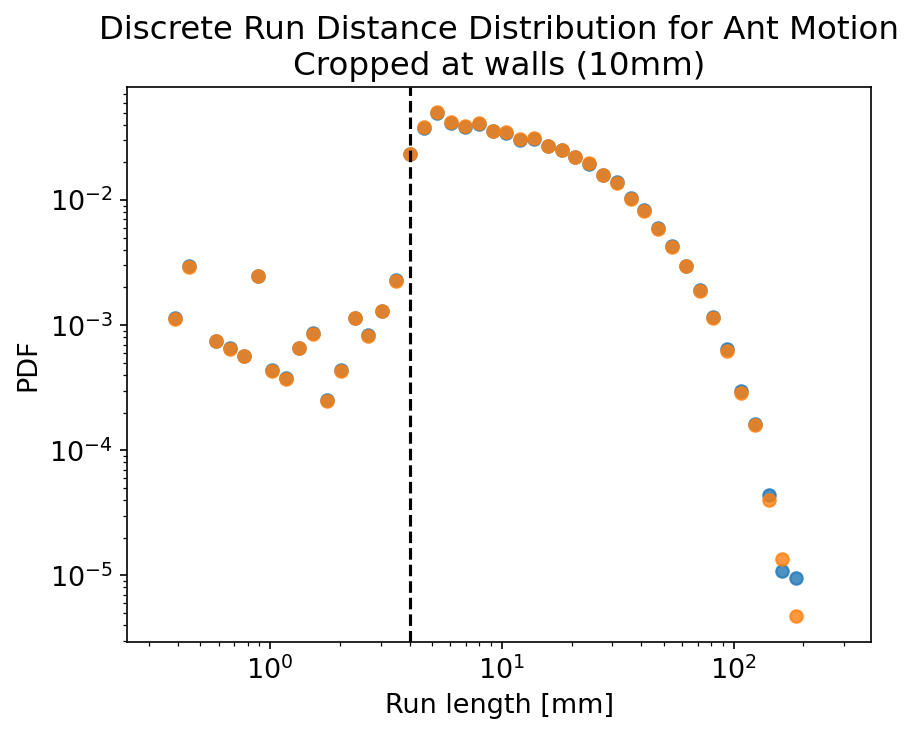

In [14]:
numBins = 50
maxDistance = 300

#bins = np.linspace(0, maxDistance, numBins+1)
bins = np.logspace(-0.5, np.log10(maxDistance), numBins+1)
binArr = (bins[1:] + bins[:-1])/2

for i in range(len(discreteStepSizeArr)):
    steps = [s for ds in discreteStepSizeArr[i] for s in ds]
    meanDist, meanBins = np.histogram(steps, bins=bins, density=True)

    plt.scatter(binArr, meanDist, label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$', alpha=0.8)
    
    # np.savetxt(f'step_dist_{angleThresholdArr[i]}.csv', meanDist)

plt.axvline(minDistancePerRun, linestyle='--', c='black')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('PDF')
plt.xlabel('Run length [mm]')
#plt.legend(fontsize=10)
#plt.title('Discrete Run Distance Distribution for Ant Motion\nUncropped')
plt.title('Discrete Run Distance Distribution for Ant Motion\nCropped at walls (10mm)')
#pltsaveall('10_DiscreteRunDistance_Cropped')
plt.show()

## Fitting the distance distribution (scipy)

In [126]:
def powerLawExpCutoff(x, alpha, A, x0, expDecay):
    """
    """
    return A * (x/x0)**(-alpha) * np.exp(-expDecay * x)

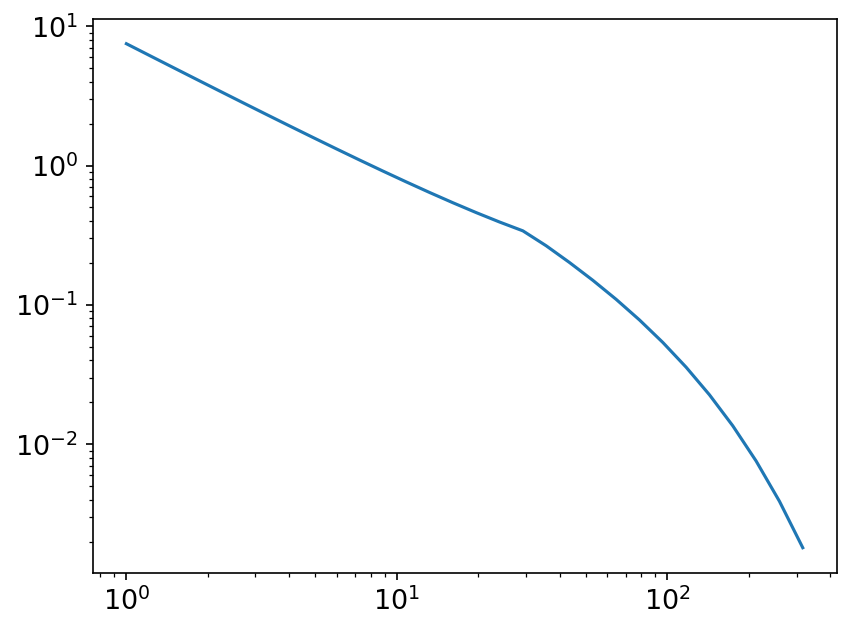

In [45]:
xArr = np.logspace(0, 2.5, 30)

plt.plot(xArr, powerLawExpCutoff(xArr, 1, 100, 0.1, 30, 0.01, 1))
plt.yscale('log')
plt.xscale('log')
plt.show()

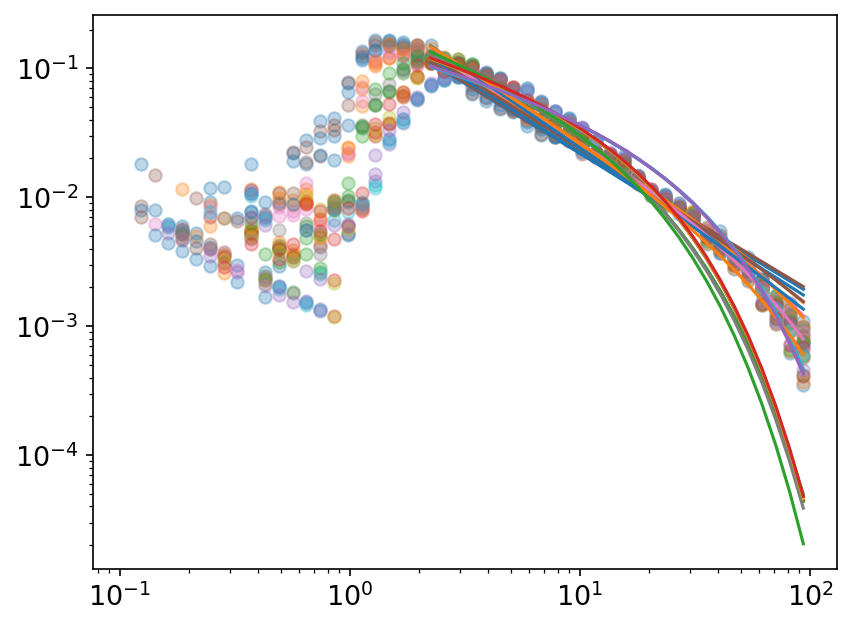

In [72]:
p0 = (1, 5, 0.1, 0.1)
xMin = 2

paramArr = np.zeros((len(discreteStepSizeArr), 4))

plt.yscale('log')
plt.xscale('log')

for i in range(len(discreteStepSizeArr)):
    steps = [s for ds in discreteStepSizeArr[i] for s in ds]
    meanDist, meanBins = np.histogram(steps, bins=bins, density=True)
    meanBins = (meanBins[1:] + meanBins[:-1]) / 2

    minIndex = np.where(meanBins >= xMin)[0][0]
    pOpt, pCov = curve_fit(powerLawExpCutoff, meanBins[minIndex:].astype(np.float64), meanDist[minIndex:].astype(np.float64), p0=p0,
                          bounds=[(0.5, 0, 0, 0), (1.5, np.inf, np.inf, 1)])

    paramArr[i] = pOpt
    plt.plot(meanBins[minIndex:], powerLawExpCutoff(meanBins[minIndex:], *pOpt))
    plt.scatter(meanBins, meanDist, label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$', alpha=0.3)

plt.show()

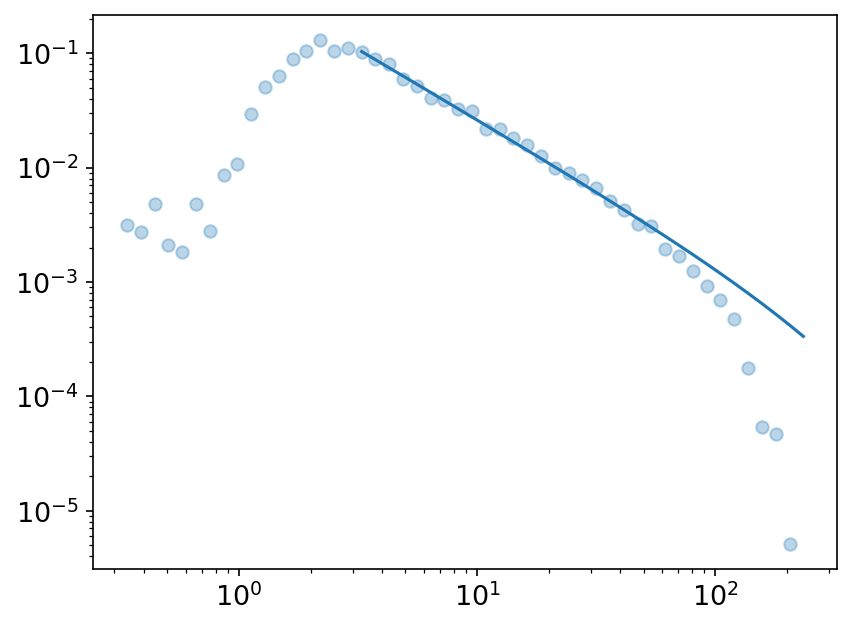

In [137]:
import lmfit

p0 = (1, 5, 0.01, 0.01)
bounds=[(0, 0, 0, 0), (2, 10, 10, 10)]

xMin = 3

paramArr = np.zeros((len(discreteStepSizeArr), 4))

plt.yscale('log')
plt.xscale('log')

for i in range(len(discreteStepSizeArr))[2:]:
    steps = [s for ds in discreteStepSizeArr[i] for s in ds]
    meanDist, meanBins = np.histogram(steps, bins=bins, density=True)
    meanBins = (meanBins[1:] + meanBins[:-1]) / 2

    minIndex = np.where(meanBins >= xMin)[0][0]
    model = lmfit.Model(powerLawExpCutoff)

    params = lmfit.create_params(alpha={"value": p0[0], "min": bounds[0][0], "max": bounds[1][0]},
                                 A={"value": p0[1], "min": bounds[0][1], "max": bounds[1][1]},
                                 x0={"value": p0[2], "min": bounds[0][2], "max": bounds[1][2]},
                                 expDecay={"value": p0[3], "min": bounds[0][3], "max": bounds[1][3]})
    
    result = model.fit(meanDist[minIndex:].astype(np.float64), x=meanBins[minIndex:].astype(np.float64),
                       params=params, method='differential_evolution')

    paramValues = [p.value for p in result.params.values()]
    paramArr[i] = paramValues
    
    plt.plot(meanBins[minIndex:], powerLawExpCutoff(meanBins[minIndex:], *paramArr[i]))
    plt.scatter(meanBins, meanDist, label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$', alpha=0.3)

    break
plt.show()

In [138]:
paramArr

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.22286203e+00, 9.63943818e-02, 3.48798430e+00, 2.20929726e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e

## Fitting the distance distribution (powerlaw)

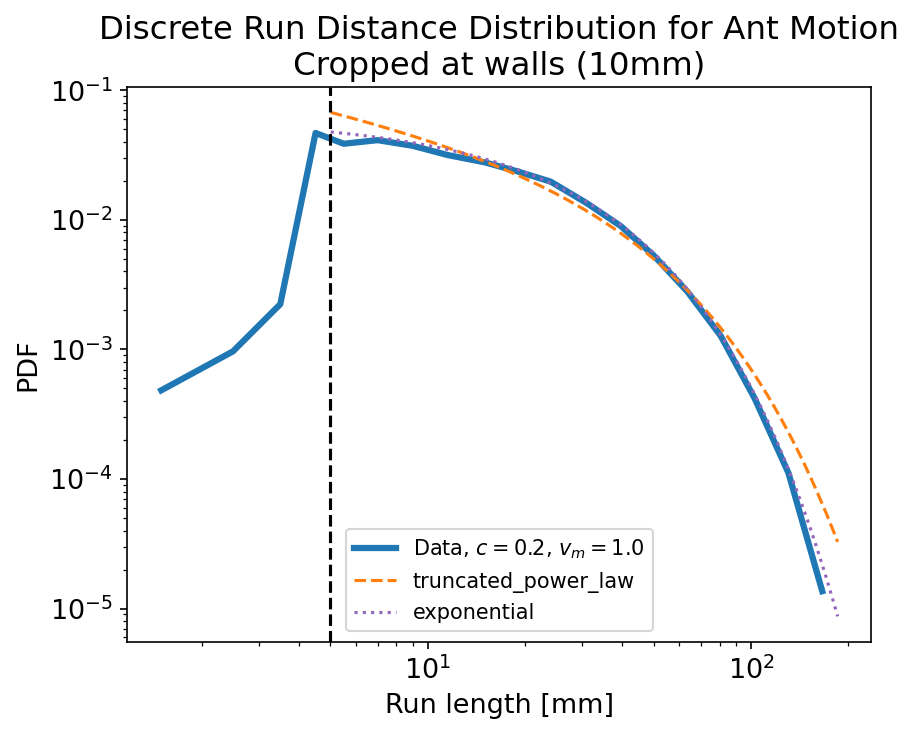

In [15]:
arenaSize = np.array([210, 150]) - (2*padding) if padding else 0 # in mm
# Minimum size of a run
xMin = 5 # [mm]

# Parameter ranges: we want to make sure to let the power law be below 1
# as of powerlaw 1.6.0 this is now the default behavior, but just in case.
parameterRanges = {'alpha': [0.5, 3.0]}

colors = list(mpl.colors.TABLEAU_COLORS)
fig, ax = plt.subplots()

for i in [0]:#range(len(discreteStepSizeArr)):
    steps = [s for ds in discreteStepSizeArr[i] for s in ds]

    fit = powerlaw.Fit(steps, xmin=xMin, xmax=np.linalg.norm(arenaSize), parameter_ranges=parameterRanges)
    
    powerlaw.plot_pdf(steps, ax=ax, xmin=1, color=colors[0], label=f'Data, $c = {cArr[i]:.2}$, $v_m = {velocityThresholdArr[i]:.2}$', linewidth=3)
    fit.truncated_power_law.plot_pdf(ax=ax, linestyle='--', color=colors[1], label='truncated_power_law')
    #fit.power_law.plot_pdf(ax=ax, linestyle='--', color=colors[1], label='truncated_power_law')
    fit.exponential.plot_pdf(ax=ax, linestyle=':', color=colors[4], label='exponential')

plt.axvline(xMin, linestyle='--', c='black')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('PDF')
plt.xlabel('Run length [mm]')
plt.legend(fontsize=10)
#plt.title('Discrete Run Distance Distribution for Ant Motion\nUncropped')
plt.title('Discrete Run Distance Distribution for Ant Motion\nCropped at walls (10mm)')
#pltsaveall('10_DiscreteRunDistance_TestFit')
plt.show()

In [16]:
1/fit.exponential.Lambda

20.92864705125601

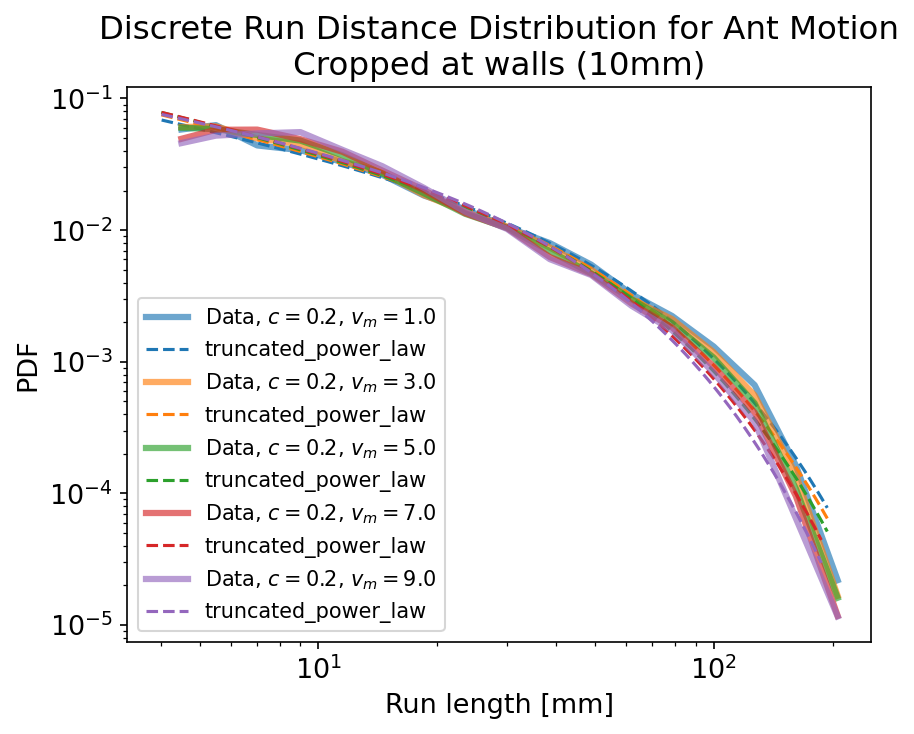

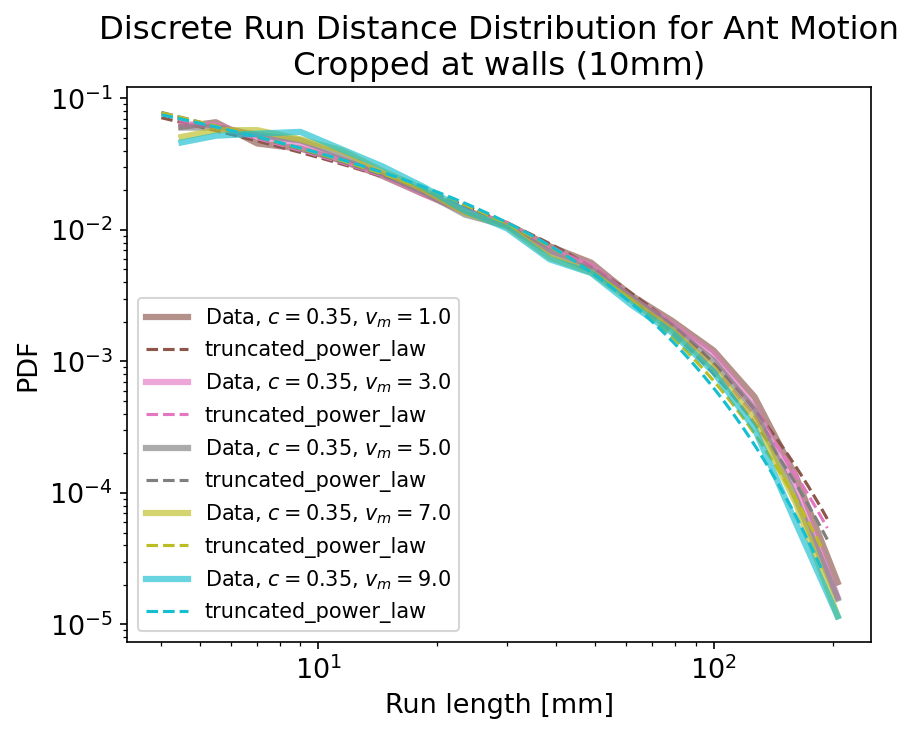

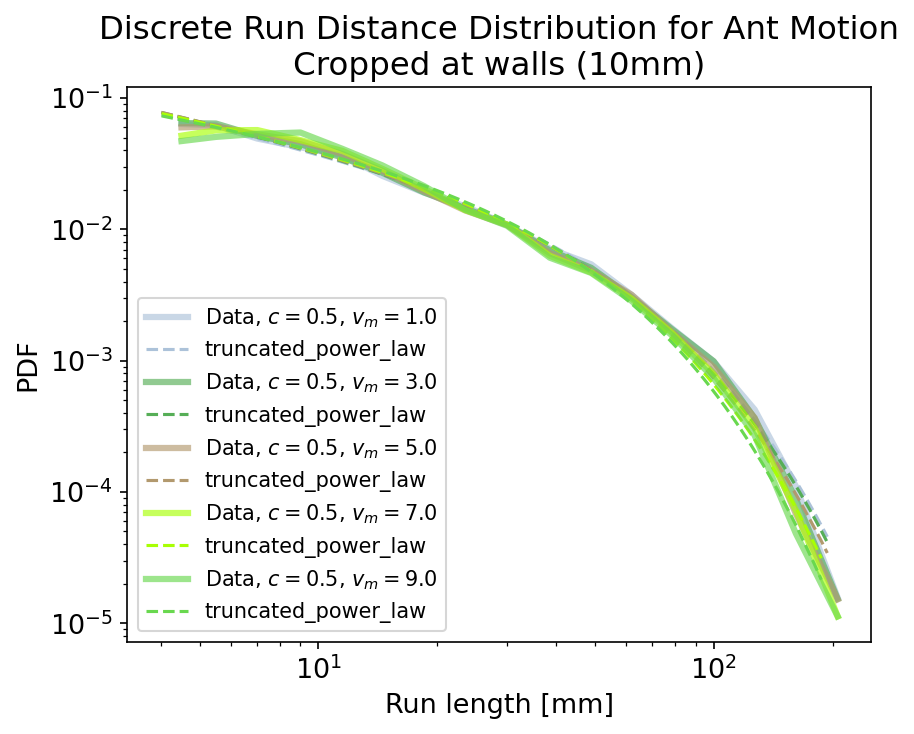

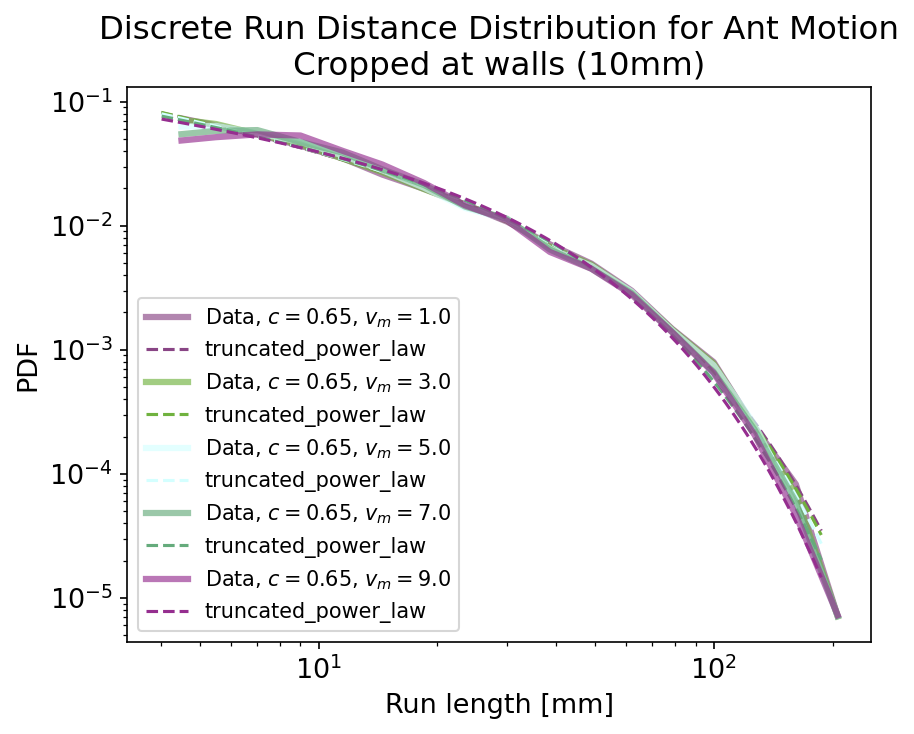

In [21]:
arenaSize = np.array([210, 150]) - (2*padding) if padding else 0 # in mm

colors = list(mpl.colors.TABLEAU_COLORS) + list(mpl.colors.XKCD_COLORS)

for j in range(4):
    fig, ax = plt.subplots()

    for i in range(len(discreteStepSizeArr))[j*5:j*5 + 5]:
        steps = [s for ds in discreteStepSizeArr[i] for s in ds]
        
        fit = powerlaw.Fit(steps, xmin=xMin, xmax=np.linalg.norm(arenaSize))
        fit.plot_pdf(ax=ax, color=colors[i], label=f'Data, $c = {cArr[i]:.2}$, $v_m = {velocityThresholdArr[i]:.2}$', linewidth=3, alpha=0.65)
        fit.truncated_power_law.plot_pdf(ax=ax, linestyle='--', color=colors[i], label='truncated_power_law')

    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('PDF')
    plt.xlabel('Run length [mm]')
    plt.legend(fontsize=10)
    #plt.title('Discrete Run Distance Distribution for Ant Motion\nUncropped')
    plt.title('Discrete Run Distance Distribution for Ant Motion\nCropped at walls (10mm)')
    pltsaveall(f'10_DiscreteRunDistance_Fits_{j}')
    plt.show()

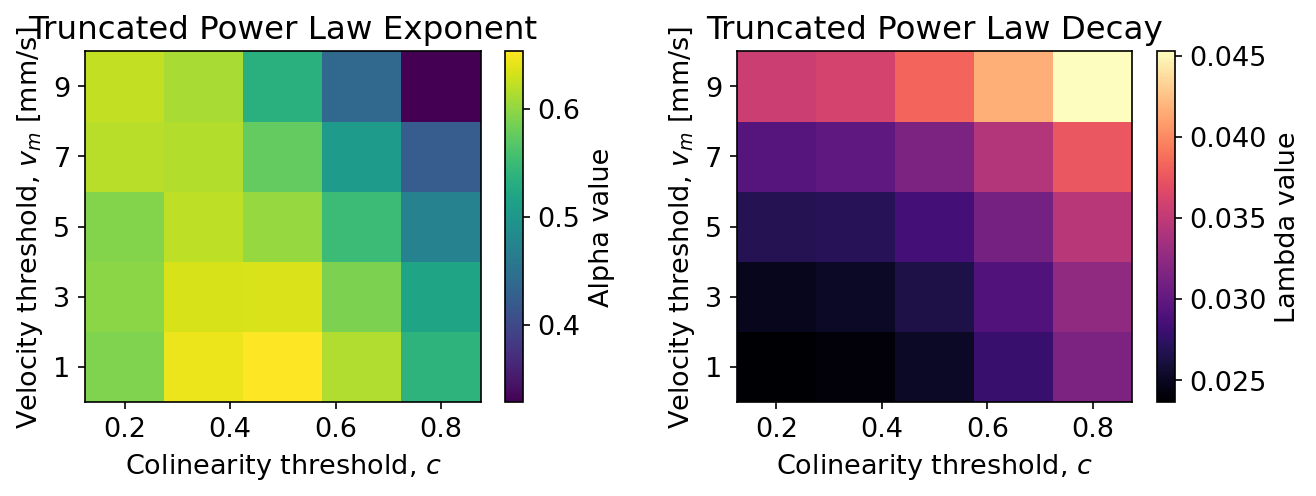

In [31]:
arenaSize = np.array([210, 150]) - (2*padding) if padding else 0 # in mm

alphaArr = np.zeros(len(discreteStepSizeArr))
lambdaArr = np.zeros(len(discreteStepSizeArr))

for i in range(len(discreteStepSizeArr)):
    steps = [s for ds in discreteStepSizeArr[i] for s in ds]

    fit = powerlaw.Fit(steps, xmin=xMin, xmax=np.linalg.norm(arenaSize))
    alphaArr[i] = fit.truncated_power_law.alpha
    lambdaArr[i] = fit.truncated_power_law.Lambda
    
uniqueCArr = np.unique(cArr)
uniqueVArr = np.unique(velocityThresholdArr)

alphaMatrix = alphaArr.reshape((len(uniqueCArr), len(uniqueVArr)))
lambdaMatrix = lambdaArr.reshape((len(uniqueCArr), len(uniqueVArr)))

fig, ax = plt.subplots(1, 2, figsize=(9.0, 3.5))

pc = ax[0].pcolor(uniqueCArr, uniqueVArr, alphaMatrix, cmap='viridis')
fig.colorbar(pc, label='Alpha value')
#plt.xticks(uniqueCArr)
ax[0].set_yticks(uniqueVArr)
ax[0].set_xlabel('Colinearity threshold, $c$')
ax[0].set_ylabel('Velocity threshold, $v_m$ [mm/s]')
ax[0].set_title(f'Truncated Power Law Exponent')

pc = ax[1].pcolor(uniqueCArr, uniqueVArr, lambdaMatrix, cmap='magma')
fig.colorbar(pc, label='Lambda value')
#plt.xticks(uniqueCArr)
ax[1].set_yticks(uniqueVArr)
ax[1].set_xlabel('Colinearity threshold, $c$')
ax[1].set_ylabel('Velocity threshold, $v_m$ [mm/s]')
ax[1].set_title(f'Truncated Power Law Decay')

fig.tight_layout()
pltsaveall('10_DiscreteRunDistance_FitParameters')
plt.show()

In [41]:
chosenDistribution = 'truncated_power_law'
alternativeDistributions = ['power_law', 'lognormal', 'exponential', 'stretched_exponential']
comparisonMatrix = np.zeros((len(discreteStepSizeArr), len(alternativeDistributions), 2))

for i in range(len(discreteStepSizeArr)):
    steps = [s for ds in discreteStepSizeArr[i] for s in ds]

    fit = powerlaw.Fit(steps, xmin=xMin, xmax=np.linalg.norm(arenaSize))
    
    for j in range(len(alternativeDistributions)):
        R, p = fit.distribution_compare(chosenDistribution, alternativeDistributions[j], normalized_ratio=True)
        comparisonMatrix[i,j] = R, p

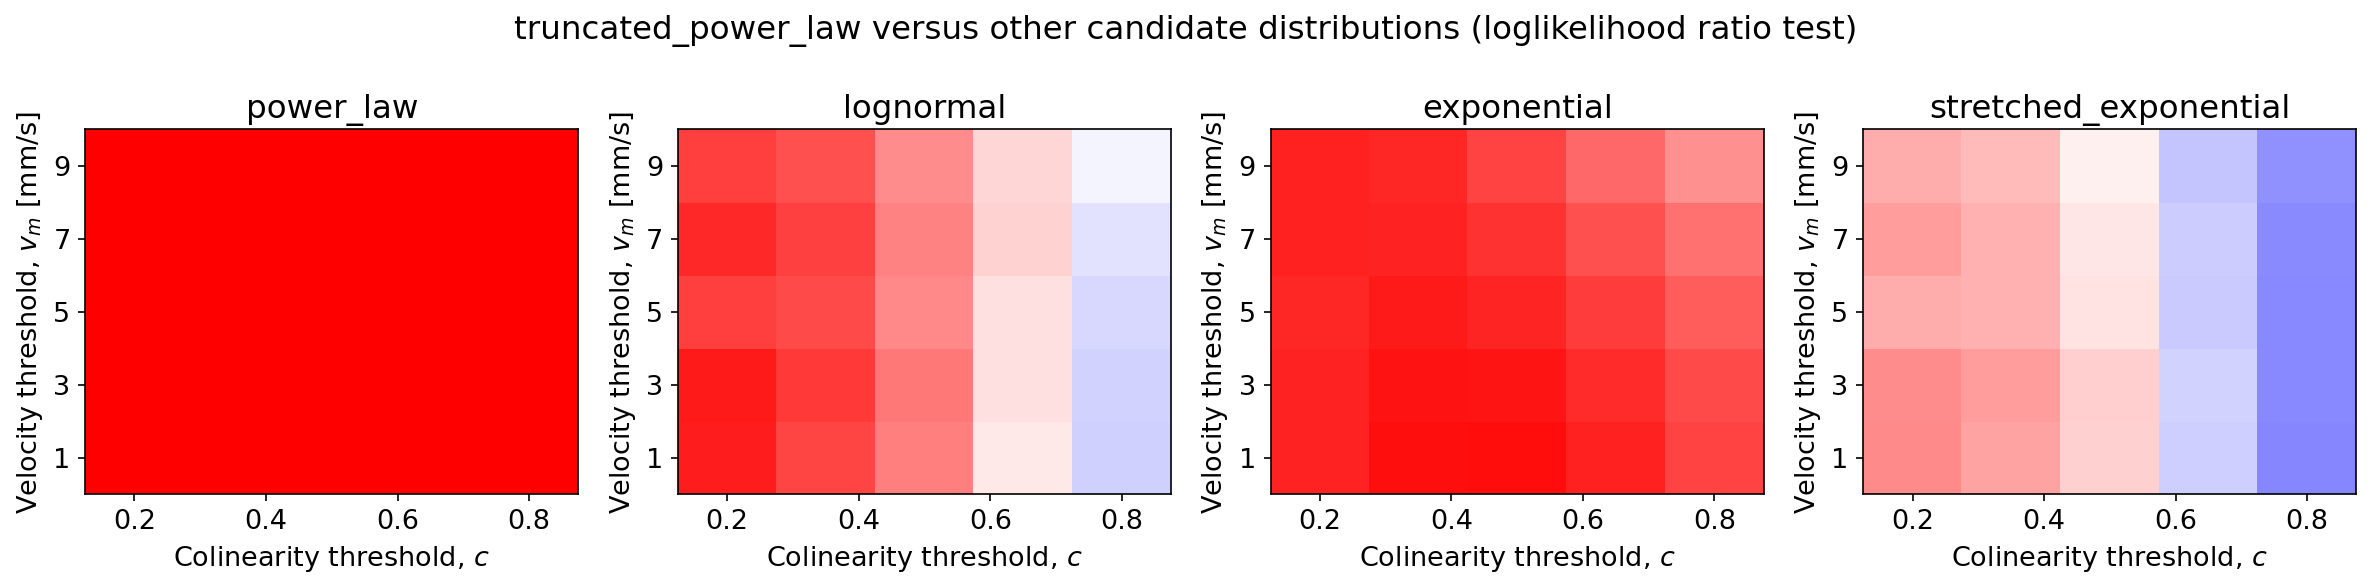

In [43]:
uniqueCArr = np.unique(cArr)
uniqueVArr = np.unique(velocityThresholdArr)

norm = mpl.colors.PowerNorm(1, vmin=-10, vmax=10)
fig, ax = plt.subplots(1, len(alternativeDistributions), figsize=(len(alternativeDistributions)*4, 4))

for i in range(len(alternativeDistributions)):

    paramMatrix = comparisonMatrix[:,i,0].reshape((len(uniqueCArr), len(uniqueVArr)))
    ax[i].pcolor(uniqueCArr, uniqueVArr, paramMatrix, cmap='bwr', norm=norm)
    #plt.xticks(uniqueCArr)
    ax[i].set_yticks(uniqueVArr)
    ax[i].set_xlabel('Colinearity threshold, $c$')
    ax[i].set_ylabel('Velocity threshold, $v_m$ [mm/s]')
    ax[i].set_title(f'{alternativeDistributions[i]}')

fig.suptitle(f'{chosenDistribution} versus other candidate distributions (loglikelihood ratio test)')
fig.tight_layout()
plt.show()

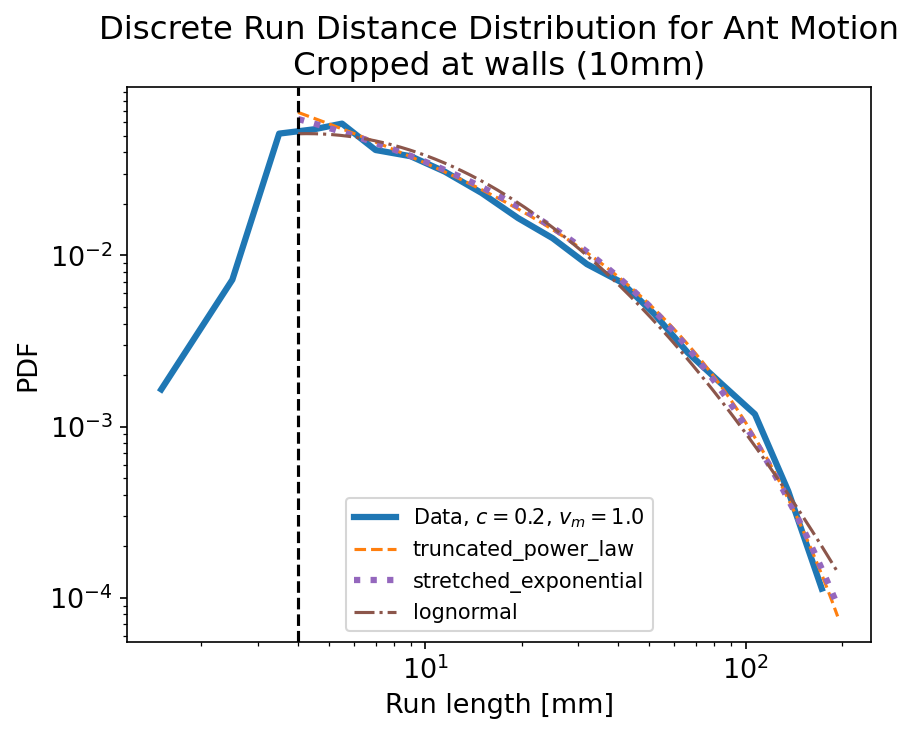

In [48]:
colors = list(mpl.colors.TABLEAU_COLORS)
fig, ax = plt.subplots()

for i in [0]:#range(len(discreteStepSizeArr)):
    steps = [s for ds in discreteStepSizeArr[i] for s in ds]

    fit = powerlaw.Fit(steps, xmin=xMin, xmax=np.linalg.norm(arenaSize), parameter_ranges=parameterRanges)
    
    powerlaw.plot_pdf(steps, ax=ax, xmin=1, color=colors[0], label=f'Data, $c = {cArr[i]:.2}$, $v_m = {velocityThresholdArr[i]:.2}$', linewidth=3)
    fit.truncated_power_law.plot_pdf(ax=ax, linestyle='--', color=colors[1], label='truncated_power_law')
    fit.stretched_exponential.plot_pdf(ax=ax, linestyle=':', color=colors[4], label='stretched_exponential', linewidth=3)
    fit.lognormal.plot_pdf(ax=ax, linestyle='-.', color=colors[5], label='lognormal')

plt.axvline(xMin, linestyle='--', c='black')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('PDF')
plt.xlabel('Run length [mm]')
plt.legend(fontsize=10)
#plt.title('Discrete Run Distance Distribution for Ant Motion\nUncropped')
plt.title('Discrete Run Distance Distribution for Ant Motion\nCropped at walls (10mm)')
#pltsaveall('10_DiscreteRunDistance_TestFit')
plt.show()

In [35]:
fit.stretched_exponential.parameters

{'Lambda': 0.05804142833979567, 'beta': 0.7293607873787535}

## Testing

Calculating best minimal value for power law fit


Fitting xmin:   4%|█                         | 85/1998 [00:00<00:02, 841.50it/s]

0.01735537903273887
0.01732104124004452
0.017279635069505583
0.017308892491204708
0.01733398005724629
0.017354286072241543
0.01741852241710573
0.017426815263439255
0.017466426266922297
0.01741629500171349
0.017372267175297162
0.01736100196602086
0.017324813709338804
0.01737718090851137
0.01752516305381291
0.01761303348824028
0.01758123062425143
0.017530986095062207
0.017571397320092497
0.017674981214557905
0.01762934835902219
0.01761007292753003
0.017595241944613593
0.017557366183861944
0.01763474515946184
0.01759013042395341
0.017559590947678894
0.017597632206419633
0.017633749476999916
0.017658284944614633
0.017620562468301904
0.017630942095828273
0.01758618363589992
0.01754461877352531
0.017546136596504835
0.017515722416893587
0.01759288153601779
0.017592816922706866
0.017572799793845184
0.017561163893926035
0.017515972924829537
0.017496272356161358
0.01747148494357753
0.017470767286586697
0.017430859767739393
0.017432486289821525
0.01741697942452014
0.01741574906086507
0.0176949822

Fitting xmin:   9%|██▏                      | 170/1998 [00:00<00:02, 843.89it/s]

0.018611471733934515


Fitting xmin:  13%|███▏                     | 255/1998 [00:00<00:02, 823.63it/s]

0.018706101700405764
0.018693228676820328
0.018830824667774637
0.019055989960113817
0.019026526492932017
0.019158640973683583
0.019293896221303286
0.019269644402085895
0.019369955978433384
0.01935467788797418
0.019521157405022138
0.019537649880923658
0.01950584642503561
0.019512508363073056
0.019441949936487513
0.019396688369256565
0.019425971359795402
0.01935399409573657
0.019312330885657425
0.019357808008796162
0.019337705179902742
0.019400567342277575
0.019325925912576536
0.01933076301032599
0.019322895187995126
0.019276308221932936
0.019182887551239425
0.019142958665708254
0.019199671040907917
0.019185350196703088
0.019180652377193796
0.0191489445610733
0.019088194623054666
0.01909231328650507
0.019063104853494717
0.018972273735867184
0.01903847047138596
0.019044685924295535
0.01902655564343747
0.018979482500369738
0.019005549378996345
0.018978959719603616
0.018900912386116686
0.018903942824764486
0.018964873407144367
0.018982946777884258
0.018922577377568084
0.018938283114287913
0

Fitting xmin:  21%|█████▎                   | 424/1998 [00:00<00:01, 827.83it/s]

0.019324952765536696
0.019290895199819857
0.019250907125707428
0.019227860283931864
0.019283471458697354
0.019285204598295747
0.019256179463273293
0.01922483375560169
0.01921919079610057
0.019194702658036134
0.019160941163584133
0.019200901301388074
0.019271509223940164
0.01930067797654411
0.019342306061357895
0.019323222158199704
0.019288169507506003
0.01924831914543501
0.019290296732195178
0.019336276113149475
0.019351140670904377
0.019337798653980665
0.019269805883783575
0.019315925942120615
0.019437471250298377
0.019417978191267227
0.019386687973570238
0.019475897657504238
0.0194538566162763
0.019428347303730442
0.019534926443735112
0.01947373516505324
0.019523406306122815
0.01945751688226105
0.01953139251864877
0.019485772258350798
0.01948419575659066
0.01962813926091933
0.019591028212354922
0.019687810329312105
0.019650642594385426
0.01973915987167718
0.01973430674647636
0.019691974095241593
0.0198542974077921
0.019808506977897822
0.01974210024415579
0.019927612918427706
0.019923

Fitting xmin:  30%|███████▍                 | 591/1998 [00:00<00:01, 821.74it/s]

0.021674645940230608
0.021761710264924905
0.021812887806074044
0.021941032166584273
0.022060306856475642
0.02201908435119493
0.022031191821196394
0.02202071528554639
0.022031572420419532
0.021976588177708756
0.02190271946319
0.021948404481459294
0.021895189031958195
0.021960246086647595
0.02200609957136046
0.02209998819028447
0.022065176806572384
0.022091563330759456
0.0221503781934268
0.022086300957394278
0.02208314881541429
0.02219423621667771
0.022325277471387017
0.022327008665788517
0.022371299138075673
0.02238009757938475
0.022435004079297105
0.022395336250841225
0.022379686223796713
0.022362595942188368
0.022319537137913126
0.022292990336732266
0.022281007861055135
0.02224426582660677
0.02232869607021637
0.022503652481372094
0.022439615289386317
0.02256011766986543
0.02251624926829332
0.022506152518394273
0.022569627837718986
0.022512968948322
0.022492064901109
0.0224591240944485
0.022471324406669324
0.02246237263024986
0.02252492777462134
0.0224798233331861
0.022433490484116136


Fitting xmin:  38%|█████████▍               | 754/1998 [00:00<00:01, 792.48it/s]

0.023252195110598284
0.023284248325321166
0.023265038493784362
0.02323680326963984
0.023279723594767376
0.023271936290938933
0.02332821693467857
0.023382679081998092
0.02344311291106571
0.023368698039360147
0.023345595273568942
0.02338696821623698
0.02357433896605754
0.023555378285583517
0.0235624335699276
0.02351337723453817
0.023569447827850754
0.023635120042693525
0.023672217314799182
0.023630058551188937
0.0237178349353665
0.023788440025165447
0.02386691209389502
0.02389292368849416
0.02386729632366924
0.02387007735997204
0.023956380737387928
0.024014511572574504
0.023975136681415266
0.02393071682748238
0.023879299692973754
0.023983449401238532
0.023989957002176876
0.023984437933475045
0.024000754804098134
0.02397680371493638
0.02398517281487389
0.023908952557297636
0.024030448080246458
0.02402130578855255
0.024007424282418754
0.024091187170162898
0.024061693987570743
0.024026664207111748
0.024012610341221263
0.023969330039561698
0.024000359894345125
0.02398914548139719
0.023933029

Fitting xmin:  46%|███████████▍             | 915/1998 [00:01<00:01, 781.05it/s]

0.025746411555675475
0.02574194809485697
0.02576672722785789
0.025736235226068827
0.025789314082461434
0.025824983286787506
0.025769539963882204
0.025835536656590552
0.02590715774469121
0.02586487910663049
0.025924179233488553
0.02592665819236928
0.02600954832511626
0.026039141371089314
0.026124687103918354
0.0261344385423935
0.02616573398728972
0.026123412034730564
0.02609005714604873
0.026061500003271676
0.026027777172455857
0.02604275049197491
0.02604306259920941
0.026034857040678927
0.026107479505433018
0.026088052936527495
0.026087921491290134
0.02609662338128038
0.02626801388923261
0.02643949255410838
0.02645849944427281
0.026438645230513202
0.026258904267733918
0.026214999650225113
0.0264881412023803
0.026506676478809443
0.026478374005505123
0.02642567724122158
0.026450208596578317
0.026444030369939586
0.026400167133483032
0.026414112305624515
0.02660110326602999
0.026759675906553038
0.026726167998012584
0.02675218982934857
0.026698085954803996
0.02686613880210653
0.026583743296

Fitting xmin:  54%|████████████▊           | 1070/1998 [00:01<00:01, 745.84it/s]

0.02906920559821513
0.0290724277673583
0.029051748733452953
0.02905037977935876
0.029054931683564766
0.02915164622410793
0.02917306094436689
0.02919812777164099
0.029200001595128366
0.0292483250594755
0.029261052608901883
0.02925122763361565
0.029273887281650368
0.02936409328500511
0.029378000434624574
0.02939553162087305
0.02938331903896607
0.0293621878428848
0.02936567035627735
0.029395354303817456
0.029444976386989397
0.029472650996179683
0.02953203001632354
0.029531036250735943
0.02953865221852503
0.02956289357160835
0.029552474337262602
0.02967755202286959
0.029769068290399714
0.029771625066292273
0.02979061477125644
0.02982070502448897
0.02996330459050056
0.029988981110586455
0.029968511059949576
0.030007468315673136
0.03001255675169845
0.030035153864672592
0.029995082609977075
0.030015350669485352
0.0300235069419732
0.03002445205782589
0.030202696471692714
0.030249660942952006
0.030214761017858693
0.030251919928216187
0.030256517662658466
0.03032155997127295
0.03042004183026925


Fitting xmin:  61%|██████████████▋         | 1221/1998 [00:01<00:01, 738.41it/s]

0.03320613703175024
0.03318936574088538
0.03324241490800772
0.03324331467667563
0.03332052569312116
0.03333644186869755
0.03334190843714635
0.033417868548090146
0.03340315485684198
0.03346835331529896
0.9988662131519276
0.9988649262202044
0.9988636363636365
0.9988623435722414
0.9988610478359911
0.998859749144812
0.9988584474885847
0.998857142857143
0.9988558352402748
0.9988545246277206
0.9988532110091745
0.9988518943742826
0.9988505747126438
0.9988492520138091
0.9988479262672812
0.9988465974625146
0.9988452655889147
0.9988439306358383
0.9988425925925927
0.9988412514484358
0.9988399071925755
0.9988385598141697
0.9988372093023257
0.9988358556461002
0.9988344988344989
0.9988331388564762
0.9988317757009347
0.9988304093567253
0.9988290398126465
0.9988276670574444
0.9988262910798124
0.9988249118683903
0.9988235294117649
0.9988221436984689
0.9988207547169813
0.9988193624557262
0.9988179669030735
0.9988165680473374
0.9988151658767774
0.9988137603795968
0.9988123515439431
0.9988109393579074
0.9

Fitting xmin:  69%|████████████████▌       | 1384/1998 [00:01<00:00, 757.13it/s]

0.9986631016042782
0.9986613119143241
0.9986595174262736
0.9986577181208055
0.9986559139784947
0.9986541049798118
0.9986522911051214
0.998650472334683
0.9986486486486488
0.9986468200270637
0.9986449864498647
0.9986431478968794
0.9986413043478263
0.9986394557823131
0.9986376021798367
0.9986357435197819
0.9986338797814209
0.9986320109439126
0.9986301369863015
0.9986282578875173
0.9986263736263737
0.9986244841815682
0.9986225895316806
0.9986206896551726
0.9986187845303869
0.9986168741355465
0.9986149584487536
0.998613037447989
0.9986111111111112
0.9986091794158555
0.998607242339833
0.9986052998605301
0.9986033519553074
0.9986013986013987
0.9985994397759105
0.9985974754558207
0.9985955056179777
0.9985935302391
0.9985915492957748
0.9985895627644571
0.9985875706214691
0.9985855728429988
0.9985835694050993
0.998581560283688
0.9985795454545456
0.9985775248933145
0.9985754985754988
0.9985734664764624
0.9985714285714288
0.9985693848354794
0.9985673352435531
0.998565279770445
0.9985632183908048
0

Fitting xmin:  75%|█████████████████▉      | 1491/1998 [00:01<00:00, 847.08it/s]

0.998281786941581
0.998278829604131
0.9982758620689657
0.9982728842832471
0.9982698961937718
0.9982668977469673
0.9982638888888891
0.9982608695652175
0.9982578397212546
0.99825479930192
0.9982517482517484
0.9982486865148864
0.9982456140350879
0.998242530755712
0.9982394366197185
0.9982363315696651
0.9982332155477034
0.9982300884955754
0.9982269503546102
0.9982238010657195
0.9982206405693952
0.9982174688057043
0.9982142857142859
0.9982110912343473
0.9982078853046596
0.998204667863555
0.9982014388489211
0.9981981981981984
0.9981949458483756
0.9981916817359857
0.9981884057971017
0.9981851179673323
0.9981818181818184
0.9981785063752279
0.9981751824817521
0.9981718464351007
0.9981684981684984
0.9981651376146791
0.9981617647058826
0.9981583793738492
0.9981549815498157
0.9981515711645104
0.9981481481481483
0.9981447124304269
0.9981412639405206
0.9981378026070765
0.9981343283582091
0.9981308411214955
0.9981273408239703
0.9981238273921202
0.9981203007518799
0.9981167608286254
0.99811320754717
0

Fitting xmin:  83%|███████████████████▊    | 1654/1998 [00:02<00:00, 662.60it/s]

0.3912953186556524
0.39094666692040736
0.39059718844012564
0.39049303366371235
0.06437809076039147
0.06451357154905568
0.06467938153268904
0.0647834345452909
0.06498180121588093
0.06506967056864676
0.0652391428681054
0.06541673085037714
0.06552586429161045
0.065642357930501
0.06580497415571263
0.06596052924931317
0.06605146421182495
0.06624962035316695
0.06636476331422025
0.06650342288450939
0.06674680496058438
0.0668747193557645
0.06702897908181993
0.06717568229851589
0.06736268882319141
0.06752469897022795
0.06771128001597448
0.06780880557170632
0.06798007375216175
0.39091945461722555
0.39067353517710973
0.3902634976666984
0.39006538878463115
0.3901241246166617
0.38985600664161363
0.3894619685166391
0.389261941876196
0.3893057673166894
0.38895125129194424
0.3889667965746253
0.3885517887191549
0.38811828441295215
0.3879213170393751
0.3887583742732482
0.38890718285105147
0.38863064857497587
0.3881843419146674
0.38845002266284595
0.3881578980961105
0.38792604985775664
0.3883404701152561

Fitting xmin:  86%|████████████████████▋   | 1724/1998 [00:02<00:00, 628.64it/s]

0.38951387952636773
0.3893900904388113
0.3889780977601955
0.3885715102801584
0.3880263810540478
0.387474747327657
0.387057600578658
0.3864726351991442
0.3867421440906024
0.3864937879903714
0.38745972465332107
0.3876541000200249
0.38715530250141644
0.38672710930409543
0.38649782261766824
0.3858368154135799
0.38540377775450685
0.38470741612799236
0.38409581347835564
0.38440627938385047
0.38541599519833986
0.3853263438228777
0.3846530716887388
0.38396737249439705
0.385326811427524
0.3857030172188126
0.38581381091935923
0.3853256598861211
0.3848856686868108
0.38468647786235133
0.38385903941618915
0.38317541355388196
0.3829517478403265
0.38260467924431446
0.38210353375104217
0.3815821605134652
0.38118973916183435
0.380999968497397
0.3805719332135035
0.3805215273052475
0.38105294586668725
0.38133756583155565
0.3805201510862739
0.3800326344689494
0.38085416228365737
0.3804118801457067
0.37963626650419113
0.3788232984764029
0.3784541436719781
0.37773245812229306
0.3767913150914758
0.3760683518

Fitting xmin:  93%|██████████████████████▏ | 1850/1998 [00:02<00:00, 566.48it/s]

0.3640418450466279
0.36279100460634517
0.36331710156241465
0.36198625868631823
0.3632671984292595
0.3624122888210202
0.3614409489600563
0.36272844489439204
0.36228851348255503
0.3616403670799207
0.36153923723375697
0.36185523185695345
0.3615766652222312
0.3650083896221607
0.36555290062728724
0.3669049873062314
0.3661721061518188
0.3684013712022432
0.36785861817022864
0.3679419791996205
0.36899295518761716
0.3683762997964871
0.37050307459515686
0.3710789785011068
0.37157073045170486
0.37141594538864287
0.3706567224317428
0.37031925746637756
0.3695854703454973
0.3728904183921729
0.3729042034061914
0.37246206649225194
0.3717079901225116
0.3717420702867456
0.3712120295540969
0.3708690564938227
0.3702973351243367
0.369388353175457
0.36880528659571915
0.36947535027133743
0.37040429451034107
0.3704561238664506
0.36996967796690367
0.3700180944638932
0.3714324298348754
0.37090495900786324
0.3712318644771703
0.37076852530856214
0.37000088451666563
0.37144509010555504
0.3709678358673835
0.3699019

Fitting xmin: 100%|████████████████████████| 1998/1998 [00:02<00:00, 713.89it/s]

0.3802059114291041
0.37804972818537635
0.3779111544183246
0.37613581265279517
0.3759110037162429
0.3741686243157771
0.3719297676826648
0.37099799369059117
0.3692250236293819
0.3684745774982058
0.36938730089001043
0.3701020974058418
0.3686253971437199
0.3673536788590383
0.3657709254257997
0.3643470232448978
0.36236744998662807
0.3594885858797961
0.35806902715544414
0.3565748068886196
0.35871433166727973
0.3570438340080793
0.3539919335797236
0.3507076810543565
0.35219938157903985
0.35116486324850094
0.34928143688772184
0.34700853776645385
0.3458890328805873
0.34511149410131037
0.34314052226187486
0.3404932694503444
0.34042424984738645
0.3361943179641594
0.3374527207098643
0.33431274443051995
0.33314553080560977
0.3302147144387335
0.3288473320990451
0.3262716090567113
0.32318226149549506
0.3223985423292726
0.31760254007190036
0.31502223702379445
0.3138683714442872
0.31010102549538854
0.30680792112338084
0.30195895031923026
0.30252991268506346
0.2988210499397074
0.30423608598370333
0.29915

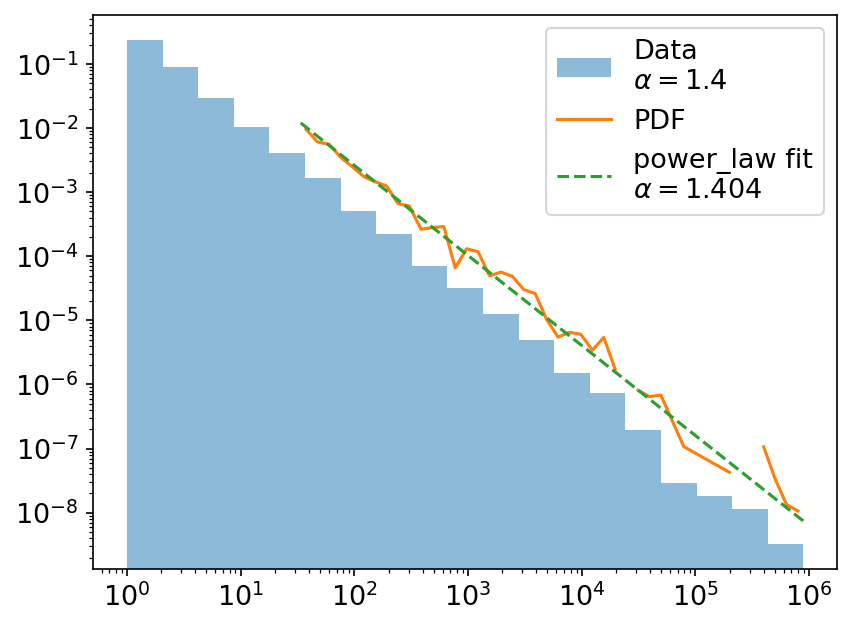

In [5]:
# A note on what I call "alpha":
# The standard convention is to call your power law
# parameter alpha, but the actual distribution scales
# with -(alpha + 1); this is done because a distribution
# that scales as x^(alpha) for |alpha| < 1 is non-normalizable.
# That being said, there can still exist such a distribution
# that is normalizable so long as it is restricted to a
# finite domain. This particular issue is relevant for such
# bounded distributions, for which we have to change the
# default parameter limits for alpha in `powerlaw`. 
# Hence, to make things clear, I will refer to the *entire*
# exponent as "alpha" below (this is the same convention as
# this package, but different from most other conventions).
np.random.seed(0)
def randomPowerLaw(alpha, xmin, xmax, size=1):
    """
    Power-law gen for:
        pdf(x) ~ x^{alpha} for xmin <= x <= xmax
        """
    r = np.random.random(size=size)
    xming, xmaxg = xmin**(alpha+1), xmax**(alpha+1)
    return (xming + (xmaxg - xming)*r)**(1./(alpha+1))
    
# Parameter ranges: We have to change the default minimum valu
# for the power law exponent to something below 1, since the power
# law might be close to one.
parameterRanges = {'alpha': [0.05, 3.5]}

# Generate fake data distributed according to a power
# law with the alpha below
realAlpha = -1.4
# Note that scipy's function cannot generate power law data
# when alpha is less than 1, so I made a custom function
# above which transforms a uniform distribution into
# a power law one
#from scipy import stats
#data = 1/stats.powerlaw.rvs(realAlpha-1, size=5000)
data = randomPowerLaw(realAlpha, xmin=1, xmax=1e6, size=2000)

#############################
# I want to do this but I can't...
#############################
#fit = powerlaw.Fit(data, xmin=1, xmax=np.max(data), fit_method='KS', verbose=2)
fit = powerlaw.Fit(data, xmax=np.max(data), fit_method='likelihood', verbose=2)
#fit.power_law.alpha = 2.0
#print(fit.power_law.KS())

# Plotting functions
fig, ax = plt.subplots()

ax.hist(data, bins=np.logspace(0, np.log10(np.max(data)), 20), label=f'Data\n$\\alpha = {-realAlpha}$', density=True, alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')

fit.plot_pdf(ax=ax, label=f'PDF')
fit.power_law.plot_pdf(ax=ax, linestyle='--', label=f'power_law fit\n$\\alpha = {fit.power_law.alpha:.5}$')

plt.legend()
plt.show()

Calculating best minimal value for power law fit


Fitting xmin: 100%|████████████████████████| 4998/4998 [00:07<00:00, 647.76it/s]


<Axes: >

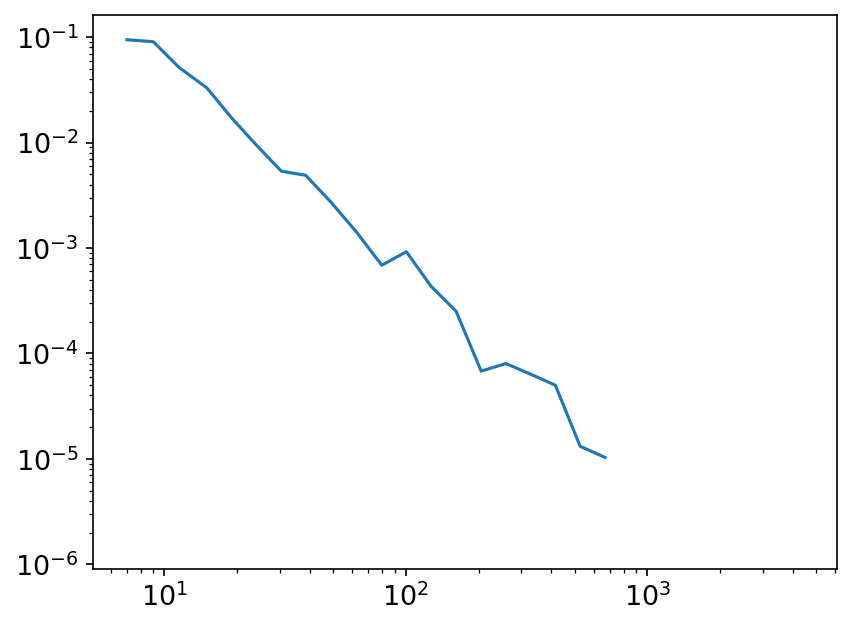

In [2]:
import powerlaw
# powerlaw Version: 1.5 (from pypi)
# I also tested the current github master branch

# Set the parameter range to be bad just to make
# sure it is being applied
parameterRanges = {'alpha': [1., 3.]}

# Generate fake data distributed according to a power
# law with the alpha below (that is outside our parameter range)
realAlpha = 2.1
from scipy import stats
data = 1/stats.powerlaw.rvs(realAlpha-1, size=5000)

# Perform our fit
# (A) This line works
fit = powerlaw.Fit(data, parameter_range=parameterRanges, verbose=True)

# (B) This line works
#fit = powerlaw.Fit(data, xmin=1)

# (C) This line will not work ("AttributeError: 'Power_Law' object has no attribute 'parent_Fit'")
#fit = powerlaw.Fit(data, xmin=1, parameter_ranges=parameterRanges, verbose=True)

fit.plot_pdf()

# # Plotting functions
# fig, ax = plt.subplots()

# ax.hist(data, bins=np.logspace(0, np.log10(np.max(data)), 20), label=f'Data\n$\\alpha = {realAlpha}$', density=True, alpha=0.5)
# ax.set_xscale('log')
# ax.set_yscale('log')

# fit.plot_pdf(ax=ax, label=f'PDF')
# fit.power_law.plot_pdf(ax=ax, linestyle='--', label=f'power_law fit\n$\\alpha = {fit.power_law.alpha:.5}$')

# plt.legend()
# #plt.savefig('test_1.png')
# plt.show()

In [2]:
print(powerlaw.__version__)
np.random.seed(0)
def randomPowerLaw(alpha, xmin, xmax, size=1):
    """
    Power-law gen for:
        pdf(x) ~ x^{alpha} for xmin <= x <= xmax
        """
    r = np.random.random(size=size)
    xming, xmaxg = xmin**(alpha+1), xmax**(alpha+1)
    return (xming + (xmaxg - xming)*r)**(1./(alpha+1))
    
# Generate fake data distributed according to a power
# law with the alpha below
realAlpha = -1.4
# Note that scipy's function cannot generate power law data
# when alpha is less than 1, so I made a custom function
# above which transforms a uniform distribution into
# a power law one
#from scipy import stats
#data = 1/stats.powerlaw.rvs(realAlpha-1, size=5000)
data = randomPowerLaw(realAlpha, xmin=1, xmax=1e6, size=2000)

pl = powerlaw.Power_Law(xmin=1, parameters=[1.5])
-np.sum(np.log(pl.pdf(data)))

1.5


8963.539844128762

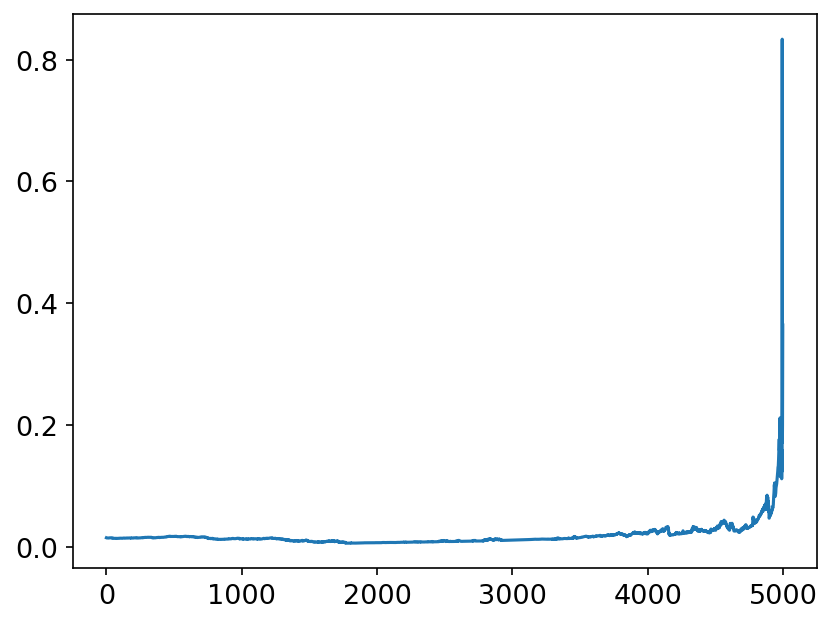

In [3]:
plt.plot(fit.Ds)

(-1.0, 3.0)

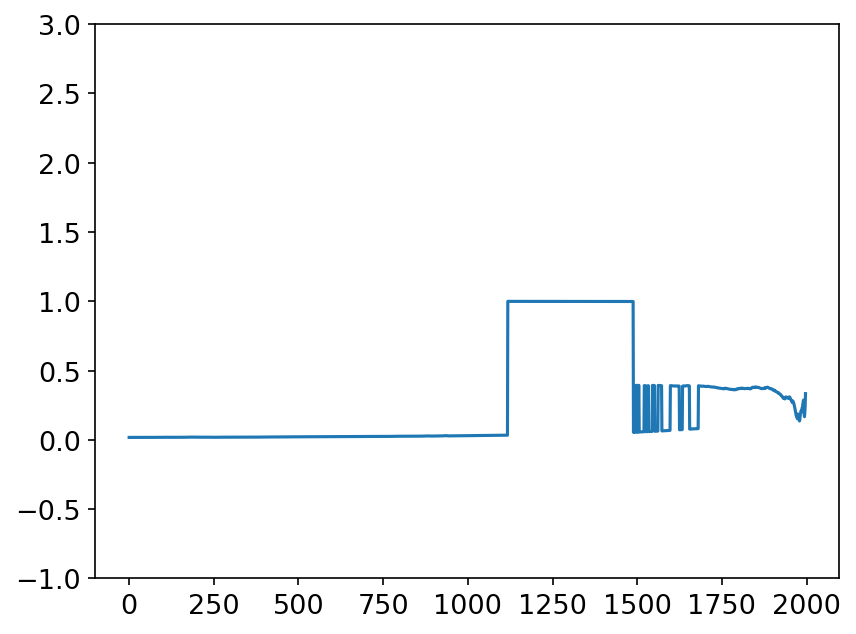

In [7]:
plt.plot(fit.distances)
plt.ylim([-1, 3])

In [40]:
array([0.62797887, 0.78933359, 0.68225325, ..., 0.55651006, 0.72240409,
       0.57931584])

0.23524273179338323

In [ ]:
0.014464296987887537
0.01440408652372982
0.014360438218800287
0.014389153078785633
0.014435458641877674
0.014474717247142554
0.014543601065394873
0.014504318756937029
0.014544174744835603
0.014491014154378035
0.014424443542693177
0.014402410367322649
0.01434740543653934
0.014428100153983103
0.01464118406174647
0.014743195962055977

In [38]:
0.014464296987887537
0.014408817690365616
0.014369877803159237
0.01440285584669021
0.014431364742428565
0.014454804565602775
0.0145647816245692
0.014491315296361718
0.014560915897778137
0.0144814223104337
0.014430906155703693

0.24368347590080752

In [ ]:
0.451325531379324